In [1]:
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from helper_functions import generate_quadratic_data, plot_optimal_val, \
    plot_quadratic_noise_data
%matplotlib inline

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.keras.backend.set_floatx('float64')
tf.autograph.set_verbosity(0)


2024-01-16 17:47:20.410071: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-16 17:47:20.411321: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 17:47:20.434576: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 17:47:20.434596: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-16 17:47:20.434614: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

**Problem Statement 1**

Test the performance of a high degree polynomial model on generated data with added noise.

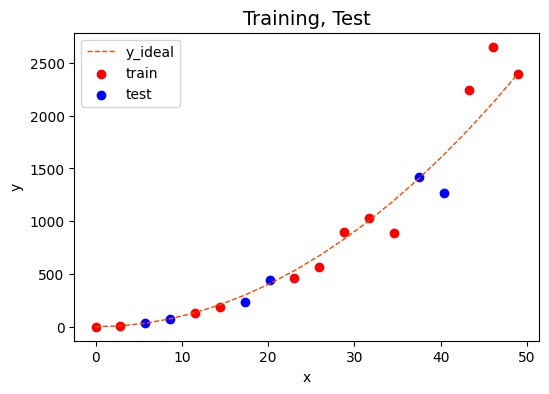

In [2]:
# Generate some data with noise following the equation x^2
X,y,y_ideal = generate_quadratic_data(18, 2, 0.7)
assert X.shape == (18,)
assert y.shape == (18,)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.33, random_state=1)

# Plot
plot_quadratic_noise_data(
    ideal=(X, y_ideal), train=(X_train, y_train), test=(X_test, y_test)
)


Calculate the error with the average squared error difference of the predicted values and the target values.

$$ J_\text{test}(\mathbf{w},b) = 
            \frac{1}{2m_\text{test}}\sum_{i=0}^{m_\text{test}-1} ( f_{\mathbf{w},b}(\mathbf{x}^{(i)}_\text{test}) - y^{(i)}_\text{test} )^2 
$$

In [3]:
def eval_mse(y: ndarray, yhat: ndarray) -> float:
    """
    Calculates the mean squared error.

    Args:
        y (ndarray): Y values.
        yhat (ndarray): Predicted y values.

    Returns:
        float: Error.
    """
    m = len(y)
    error = (yhat - y) ** 2
    return np.sum(error) / (2 * m)

y_hat = np.array([2.4, 4.2])
y_tmp = np.array([2.3, 4.1])
result = eval_mse(y_hat, y_tmp)
assert np.isclose(result, 0.005, atol=1e-6)

y_hat = np.array([3.])
y_tmp = np.array([0.])
result = eval_mse(y_hat, y_tmp)
assert np.isclose(result, 4.5)


Create a high degree polynomial model to compare performance on the training and test data.

In [4]:
def predict(model, poly, scaler, x_val: ndarray) -> ndarray:
    """
    Predicts values using the model defined above.

    Args:
        x_val (ndarray): X values.

    Returns:
        ndarray: Predicted values.
    """
    X_mapped = poly.transform(x_val.reshape(-1,1))
    X_mapped_scaled = scaler.transform(X_mapped)
    yhat = model.predict(X_mapped_scaled)
    return yhat


def train(model, poly, scaler, x_val, y_val):
    X_train_mapped = poly.fit_transform(x_val.reshape(-1,1))
    X_train_mapped_scaled = scaler.fit_transform(X_train_mapped)
    model.fit(X_train_mapped_scaled, y_val)

Training error: 58.01, Test error: 171215.01


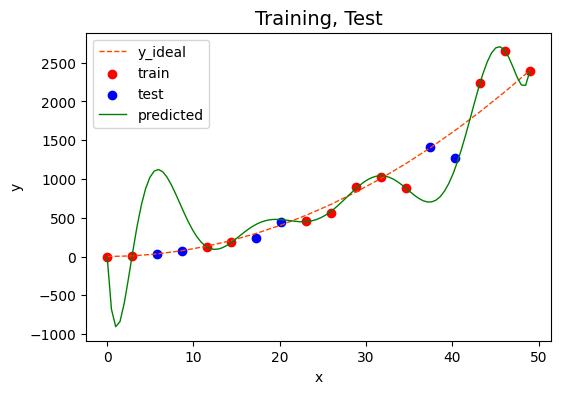

In [5]:
# Create a model
linear_model = LinearRegression()
poly = PolynomialFeatures(10, include_bias=False)
scaler = StandardScaler()

# Fit the model
train(linear_model, poly, scaler, X_train, y_train)

# Predict on training data and test data, then find error
err_train = eval_mse(y_train, predict(linear_model, poly, scaler, X_train))
err_test = eval_mse(y_test, predict(linear_model, poly, scaler, X_test))

# Plot the model
print(f"Training error: {err_train:0.2f}, Test error: {err_test:0.2f}")
x_pred = np.linspace(0,int(X.max()), 100)
y_pred = predict(linear_model, poly, scaler, x_pred)
plot_quadratic_noise_data(
    ideal=(X, y_ideal), train=(X_train, y_train),
    test=(X_test, y_test), predict=(x_pred, y_pred)
)


The model fits the training data very well, but for it to be possible it has created a complex function. The model does not do well on the test data, which indicates it is overfitting, has high variance and generalizes poorly.

**Problem statement 2**

Use a cross-validation set to determine the best degree of the polynomial model and the best lambda value.

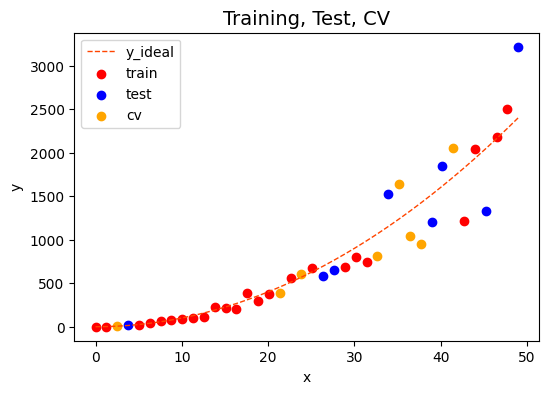

In [6]:
# Generate some data with noise following the equation x^2
X,y,y_ideal = generate_quadratic_data(40, 5, 0.7)
assert X.shape == (40,)
assert y.shape == (40,)

# Split the data
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)

# Plot
plot_quadratic_noise_data(
    ideal=(X, y_ideal), train=(X_train, y_train),
    test=(X_test, y_test), cv=(X_cv, y_cv)
)

Train the model repeatedly, increasing the degree of the polynomial each iteration, then plot findings.

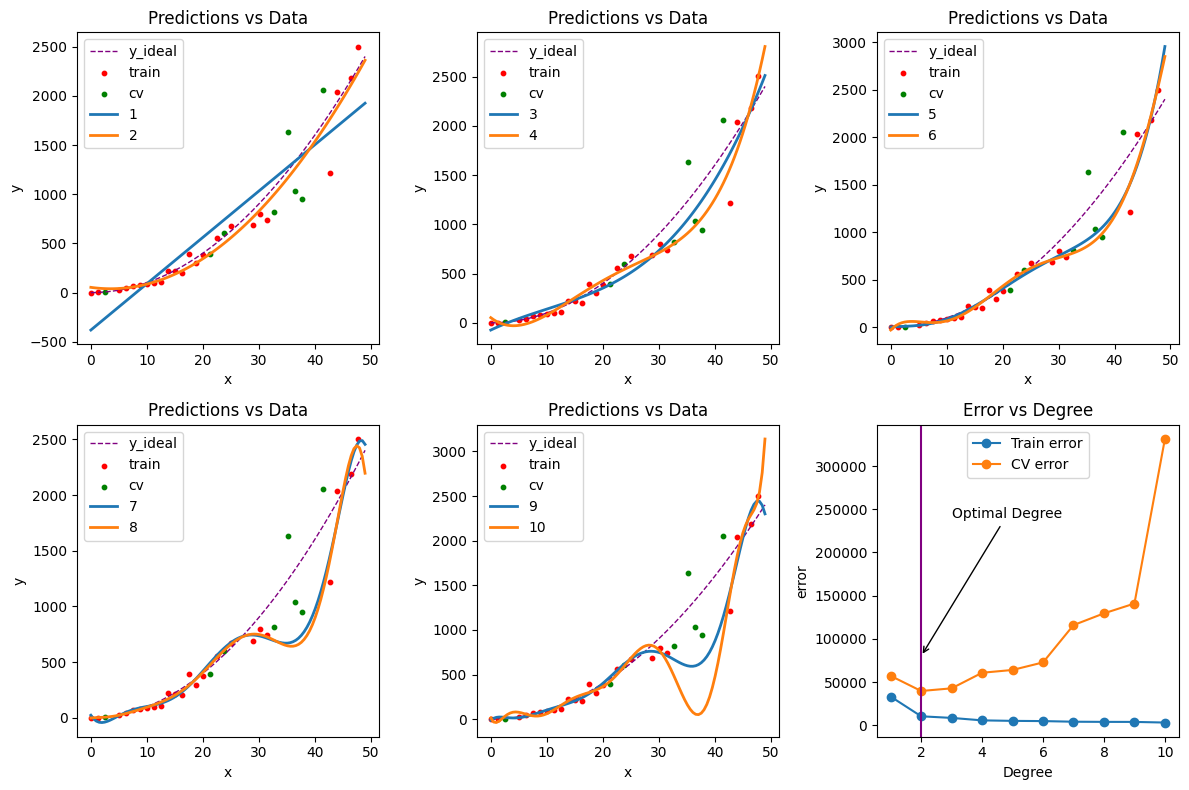

In [7]:
max_degree = 10
err_train = np.zeros(max_degree)
err_cv = np.zeros(max_degree)
x = np.linspace(0,int(X.max()),100)
y_pred = np.zeros((100, max_degree))

for degree in range(max_degree):
    # Create model
    linear_model = LinearRegression()
    poly = PolynomialFeatures(degree + 1, include_bias=False)
    scaler = StandardScaler()

    # Fit the model
    train(linear_model, poly, scaler, X_train, y_train)

    # Predict and get error
    err_train[degree] = eval_mse(y_train, predict(linear_model, poly, scaler, X_train))
    err_cv[degree] = eval_mse(y_cv, predict(linear_model, poly, scaler, X_cv))
    y_pred[:, degree] = predict(linear_model, poly, scaler, x)

optimal_degree = np.argmin(err_cv)+1

# Plot
plot_optimal_val(
    ideal=(X, y_ideal), train=(X_train, y_train), cv=(X_cv, y_cv),
    pred=(x, y_pred), errors=(err_train, err_cv),
    max_degree=max_degree, optimal_val=optimal_degree
)

Determine the best regularization parameter.

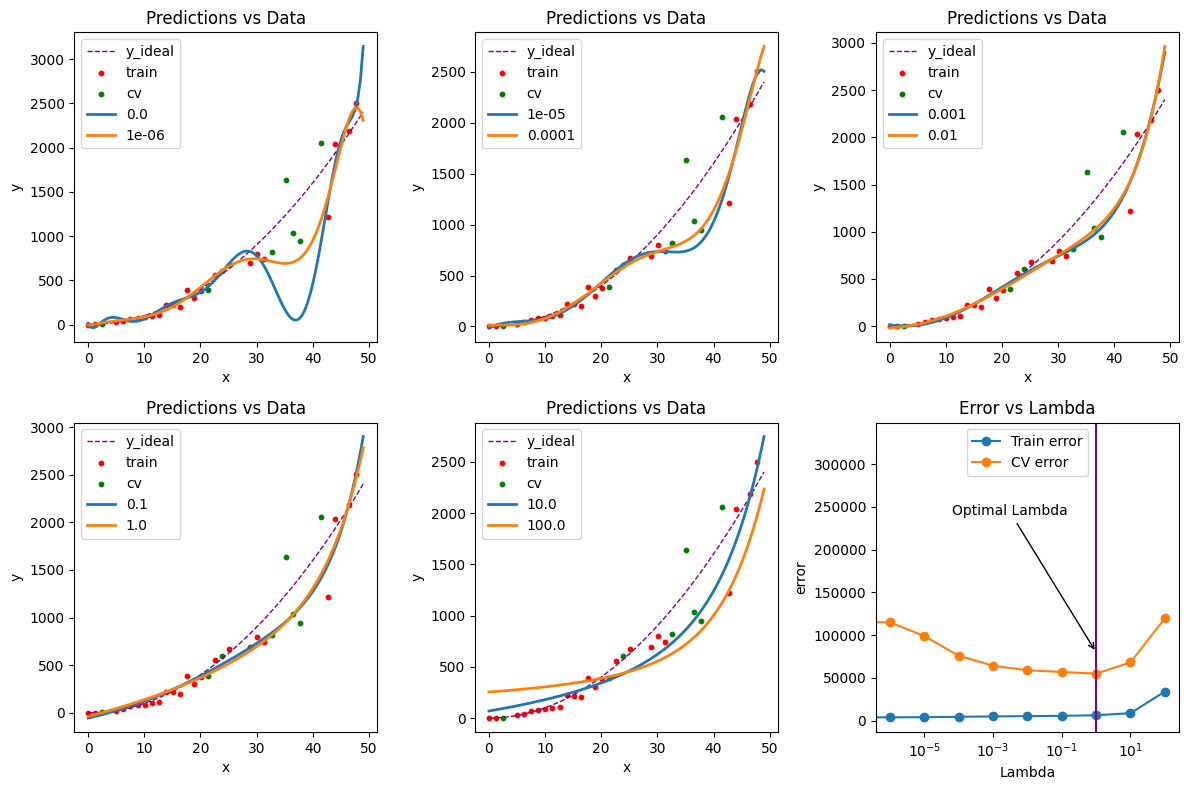

In [8]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100])
num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)
err_cv = np.zeros(num_steps)
x = np.linspace(0,int(X.max()),100)
y_pred = np.zeros((100,num_steps))

for i in range(num_steps):
    # Create model
    lambda_= lambda_range[i]
    lmodel = Ridge(alpha=lambda_)
    poly = PolynomialFeatures(degree, include_bias=False)
    scaler = StandardScaler()

    # Fit model
    train(lmodel, poly, scaler, X_train, y_train)

    # Get predictions and errors
    yhat = predict(lmodel, poly, scaler, X_train)
    err_train[i] = eval_mse(y_train, yhat)
    yhat = predict(lmodel, poly, scaler, X_cv)
    err_cv[i] = eval_mse(y_cv, yhat)
    y_pred[:,i] = predict(lmodel, poly, scaler, x)

optimal_reg_idx = np.argmin(err_cv)

# Plot
plot_optimal_val(
    ideal=(X, y_ideal), train=(X_train, y_train), cv=(X_cv, y_cv),
    pred=(x, y_pred), errors=(err_train, err_cv),
    max_degree=degree, optimal_val=optimal_reg_idx, lambdas=lambda_range
)